In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

In [4]:
from astropy.io import fits

f = fits.getdata('../libra/data/trappist_everest_luger.fits')

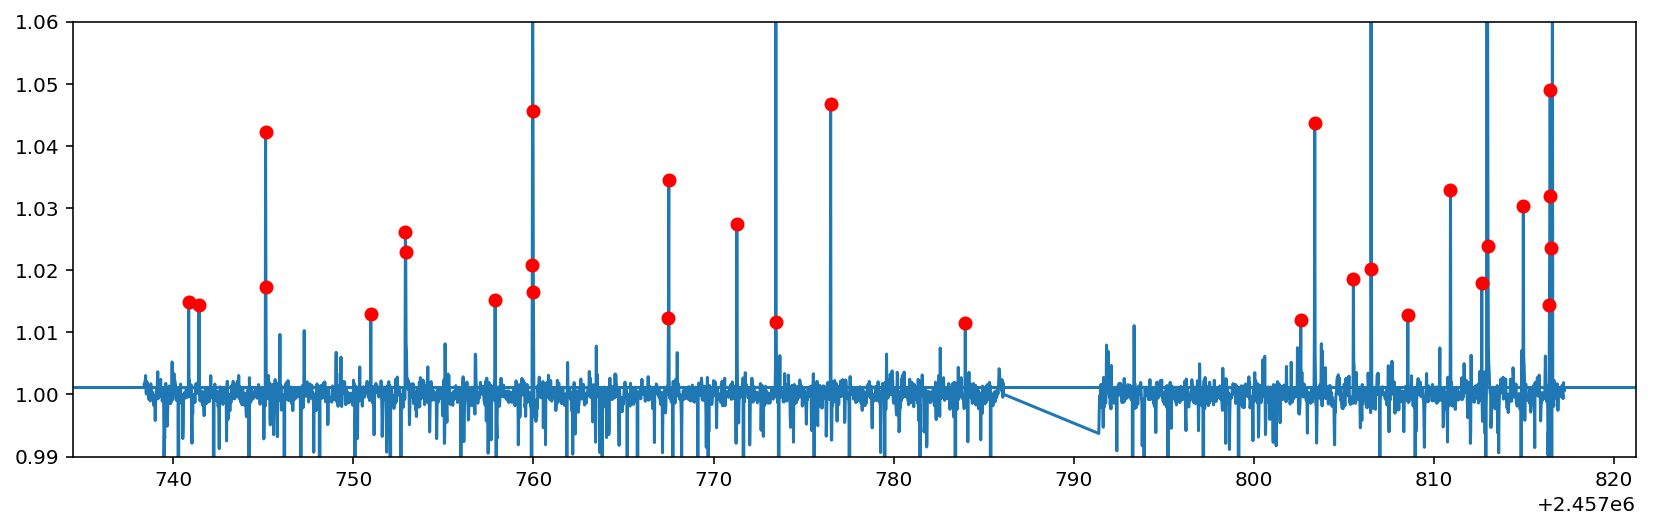

In [5]:
%matplotlib inline
k2_time, k2_flux = f['TIME'] + 2454833, f['FLUX']

mask = (k2_flux > 0)

k2_flux /= np.median(k2_flux[mask])

from scipy.signal import medfilt

# p = np.polyfit(k2_time[mask], medfilt(k2_flux[mask], (31,)), 4)

med_filt = medfilt(k2_flux[mask], (31,))
filtered_fluxes = k2_flux[mask]/med_filt

from astropy.stats import mad_std
threshold = mad_std(filtered_fluxes)

candidate_flares = filtered_fluxes > 1.01 + threshold

#k2_flux += 1 - np.polyval(p, k2_time)
plt.figure(figsize=(14, 4))
plt.plot(k2_time[mask], filtered_fluxes)

plt.plot(k2_time[mask][candidate_flares], filtered_fluxes[candidate_flares], 'ro')

plt.ylim([0.99, 1.06])
plt.axhline(1+threshold)
# plt.xlim([2457740, 2457742])

In [47]:
k2_time[mask][candidate_flares]

array([ 2457740.8491317 ,  2457741.42123857,  2457745.11949007,
        2457745.13992235,  2457750.96309838,  2457752.88371535,
        2457752.90414742,  2457757.86911462,  2457759.93273949,
        2457759.9531715 ,  2457759.9736034 ,  2457759.99403521,
        2457767.49251746,  2457767.51294912,  2457771.29281912,
        2457773.45857741,  2457773.47900917,  2457776.50289287,
        2457783.98085407,  2457802.61439357,  2457803.39079186,
        2457805.53610374,  2457806.5168182 ,  2457806.53724975,
        2457808.55997456,  2457810.9300382 ,  2457812.66672449,
        2457812.95276713,  2457812.97319864,  2457812.99363035,
        2457813.01406197,  2457814.97549825,  2457816.42614548,
        2457816.44657713,  2457816.46700869,  2457816.48744044,
        2457816.58959873])

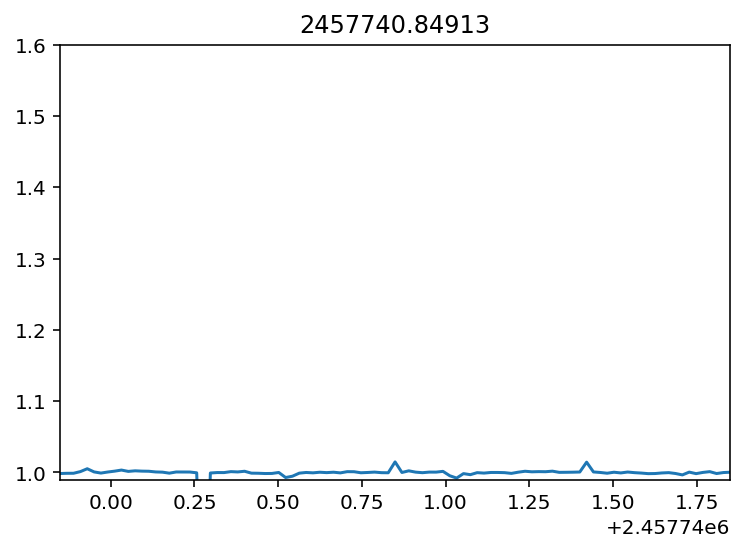

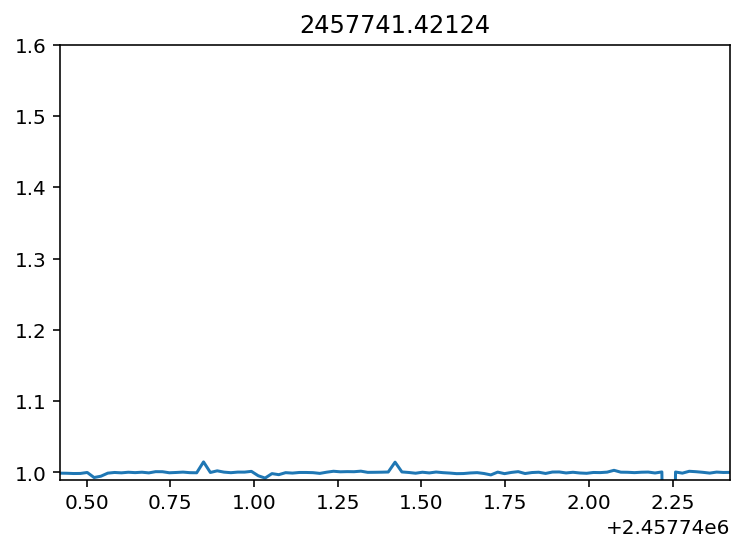

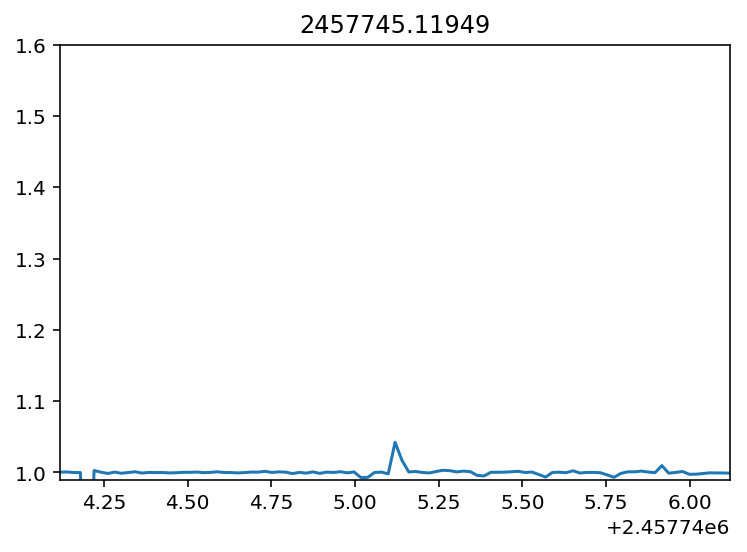

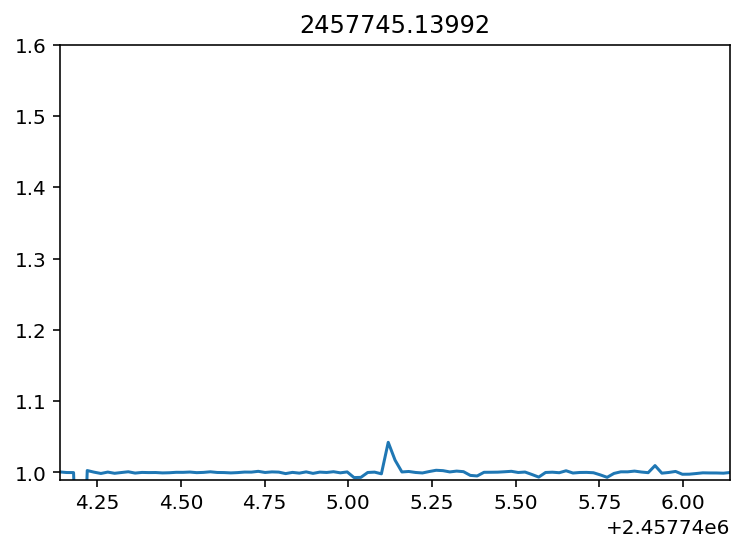

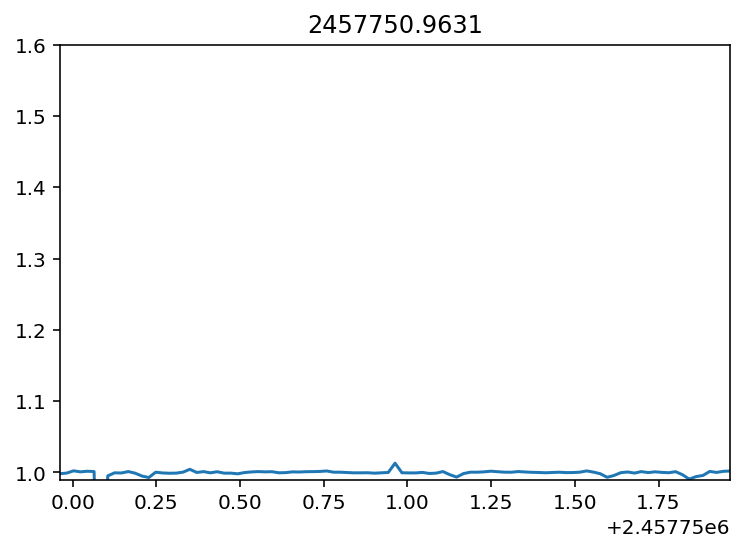

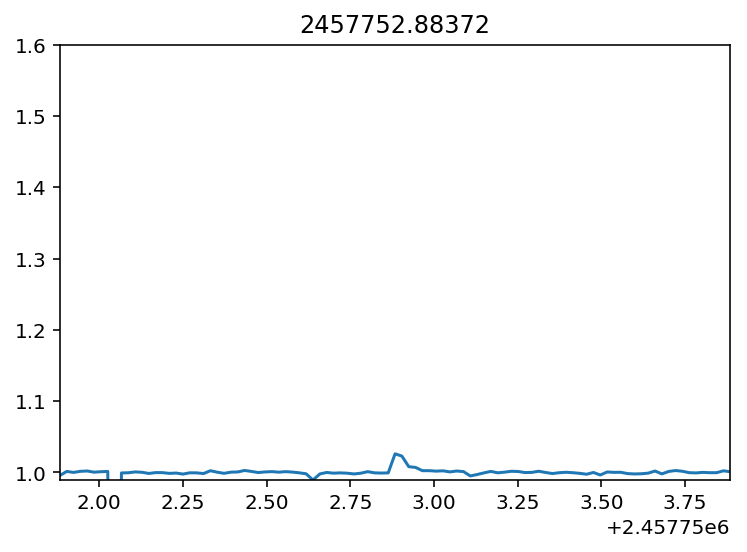

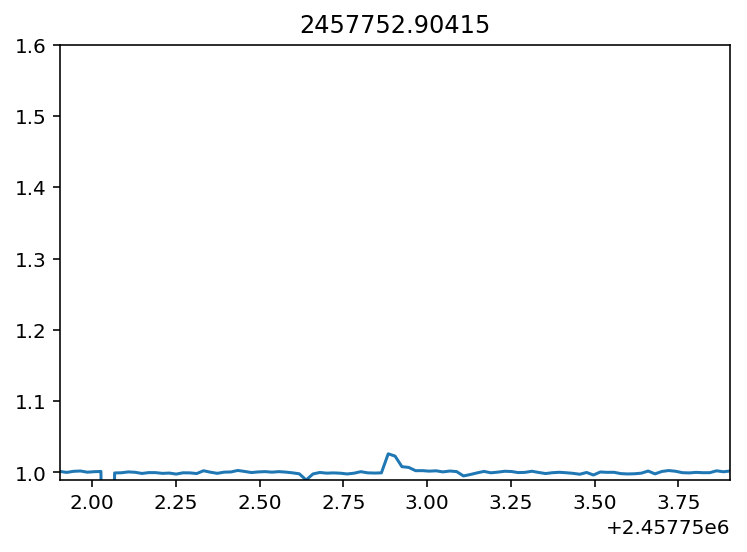

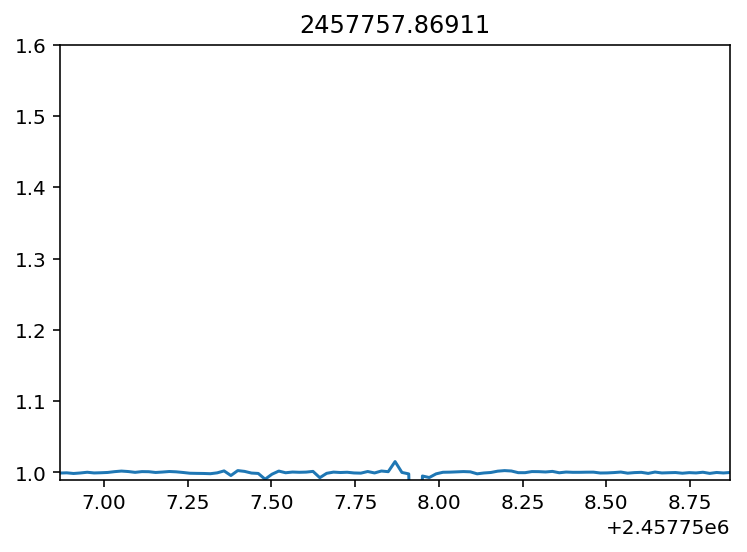

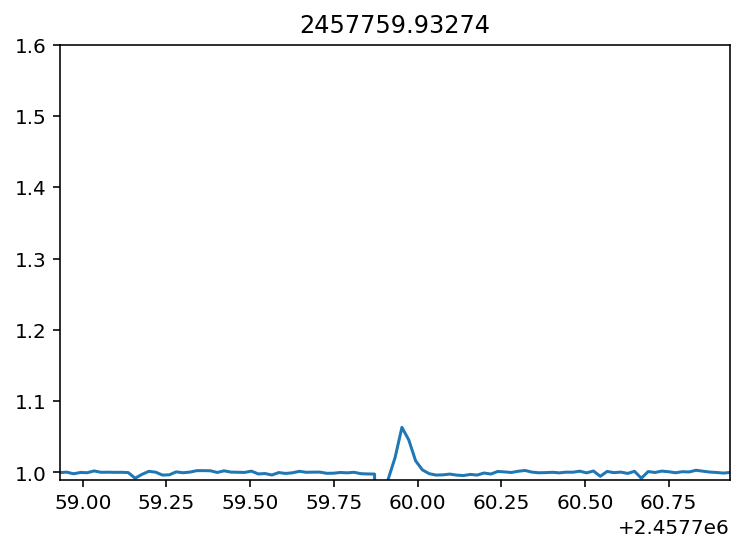

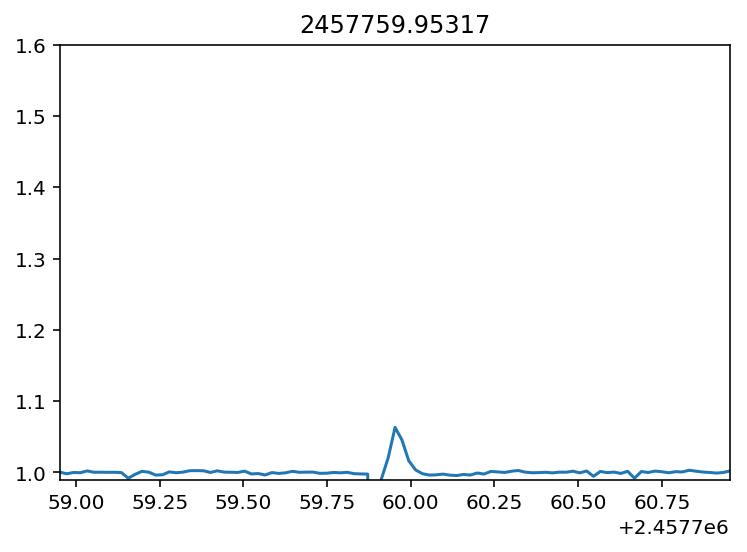

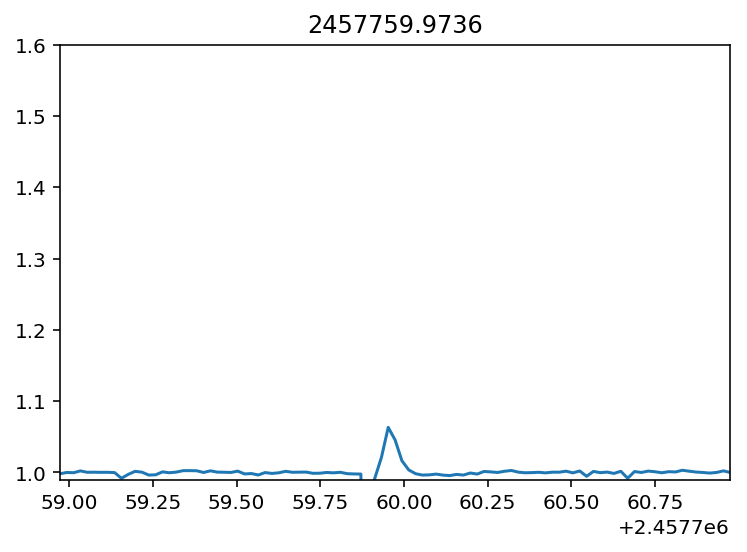

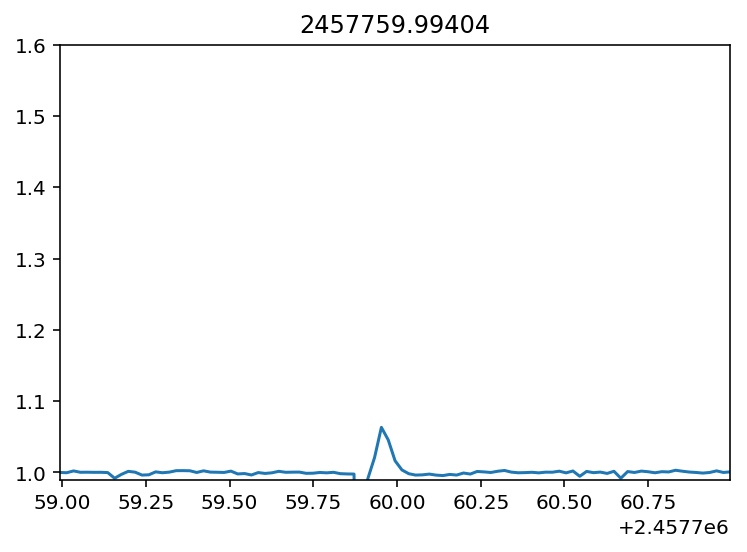

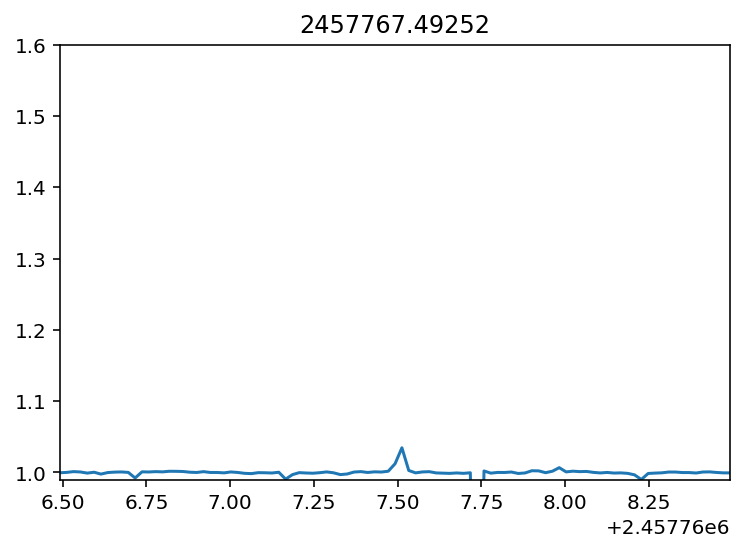

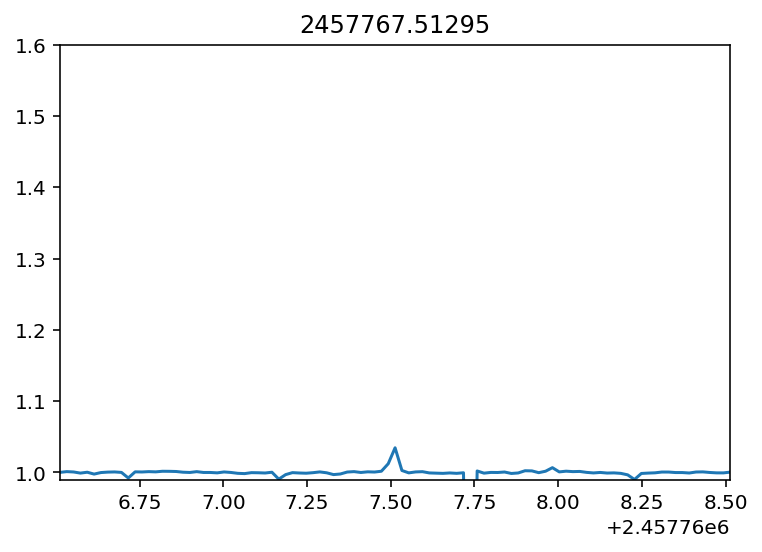

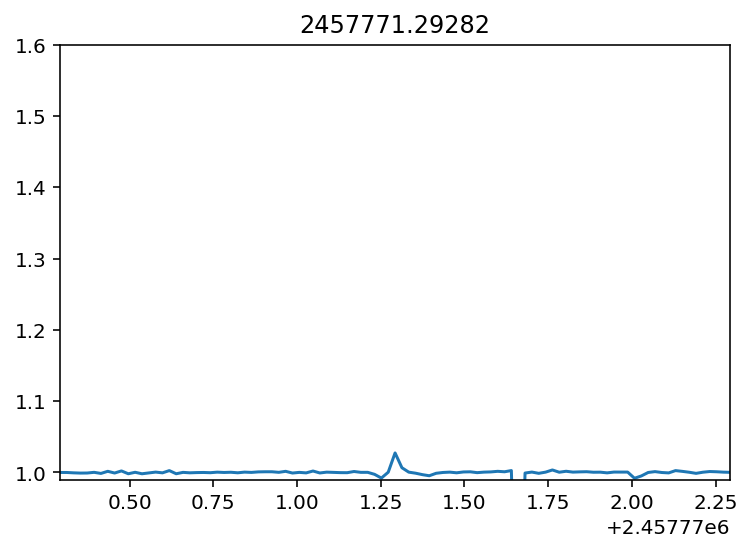

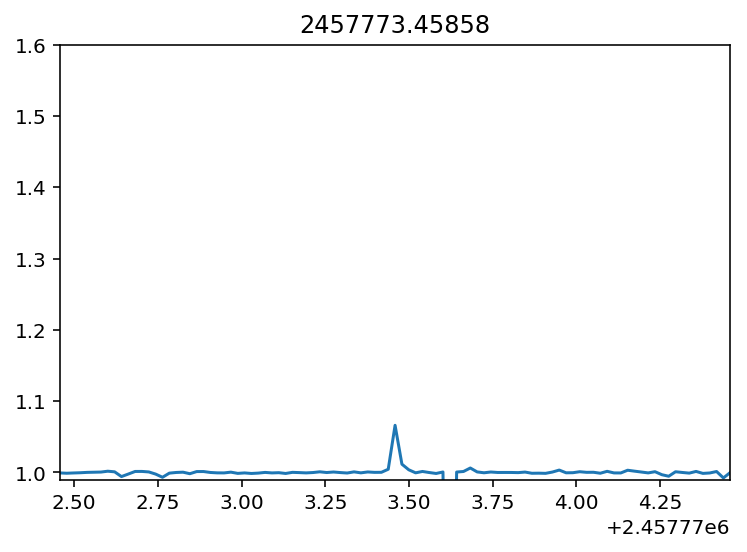

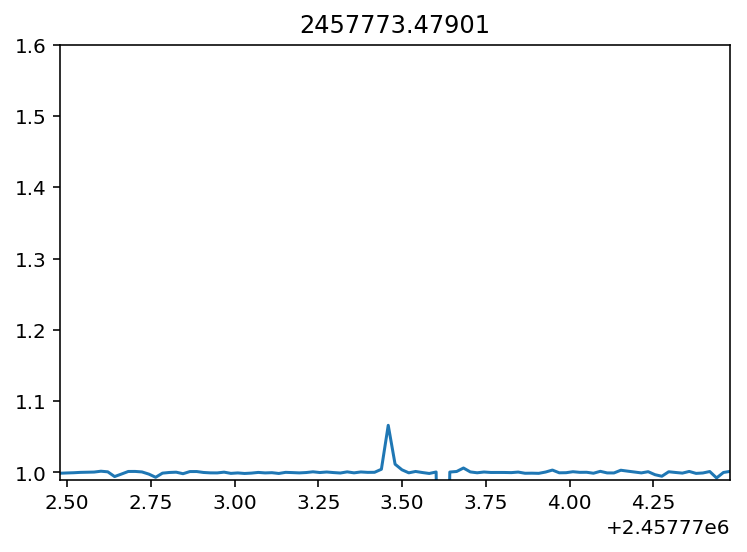

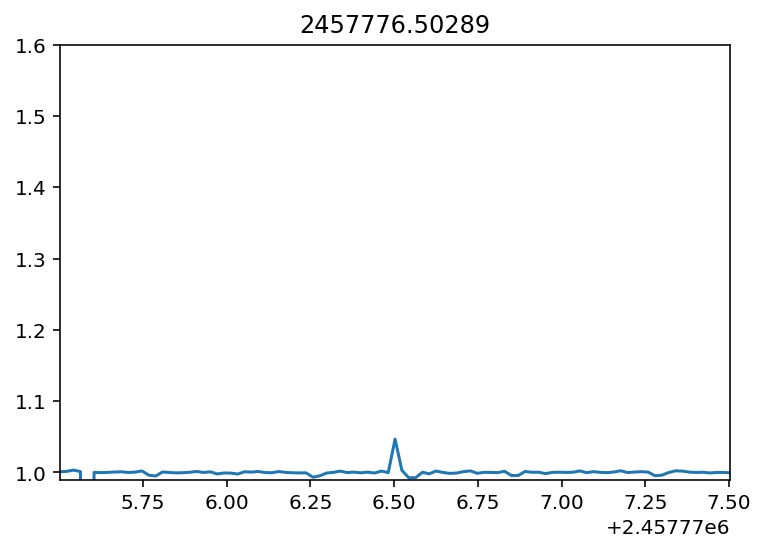

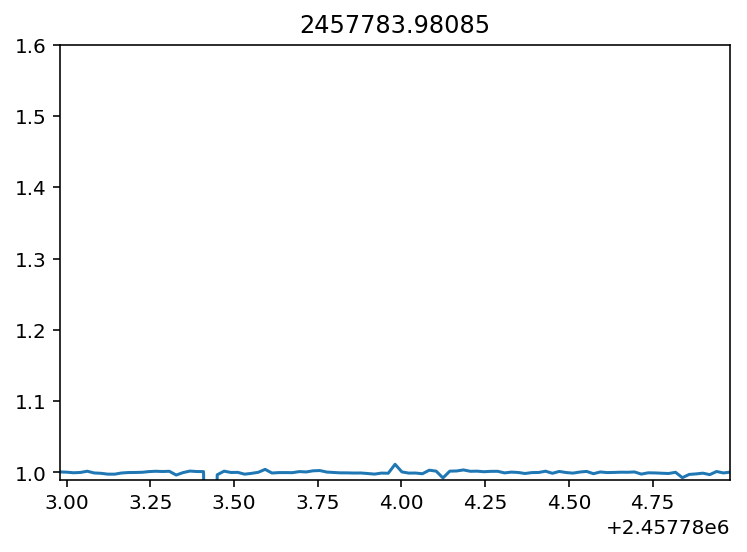

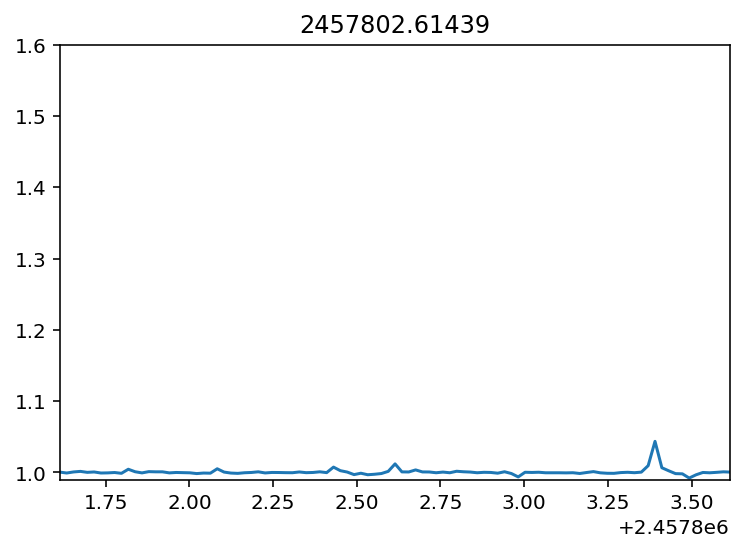

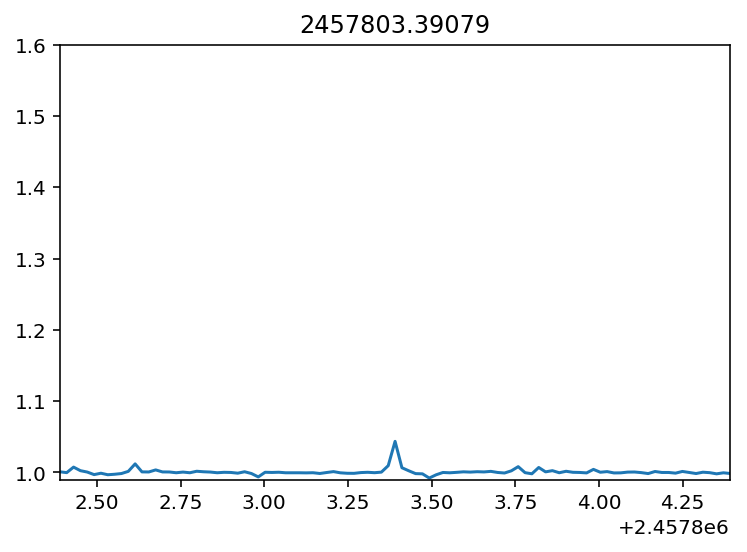

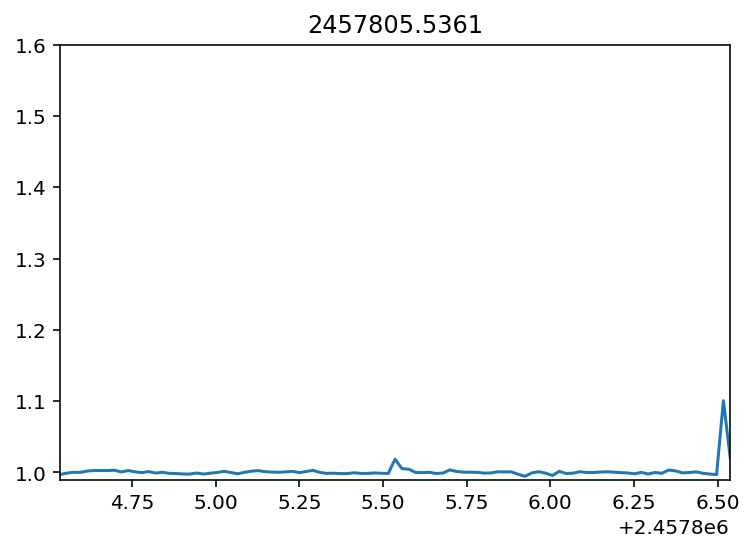

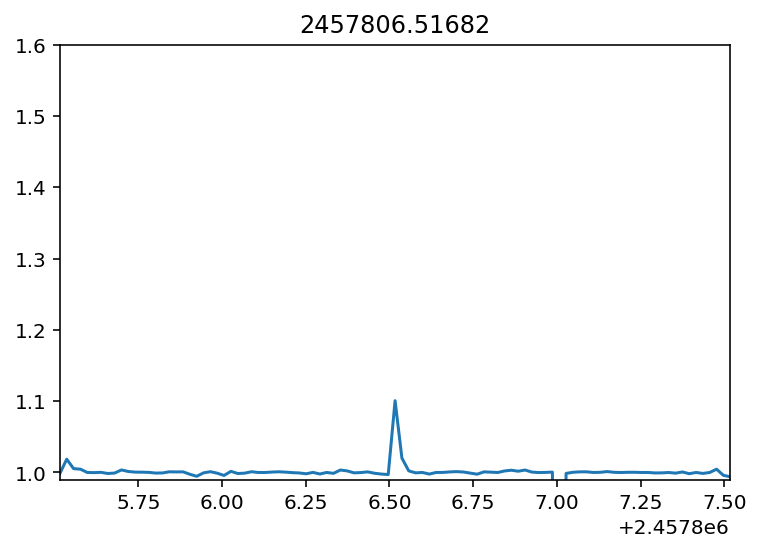

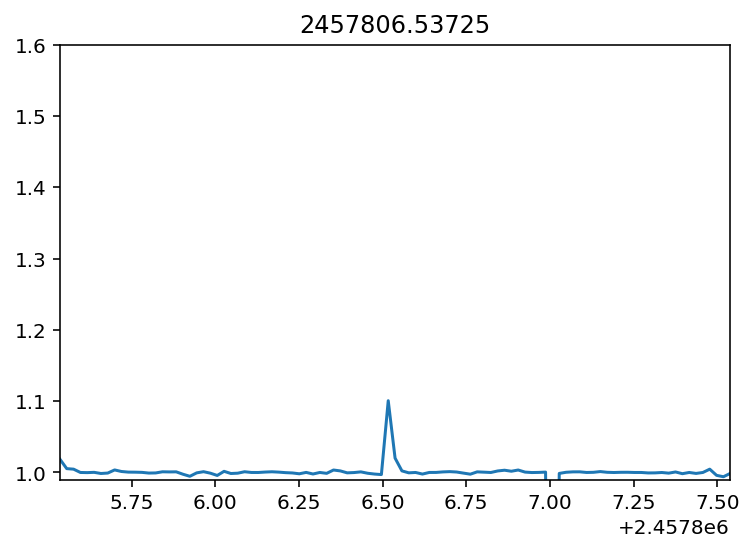

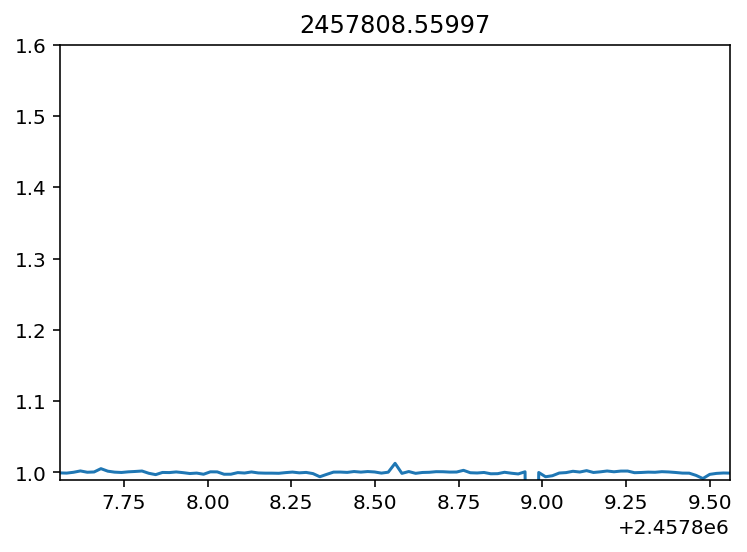

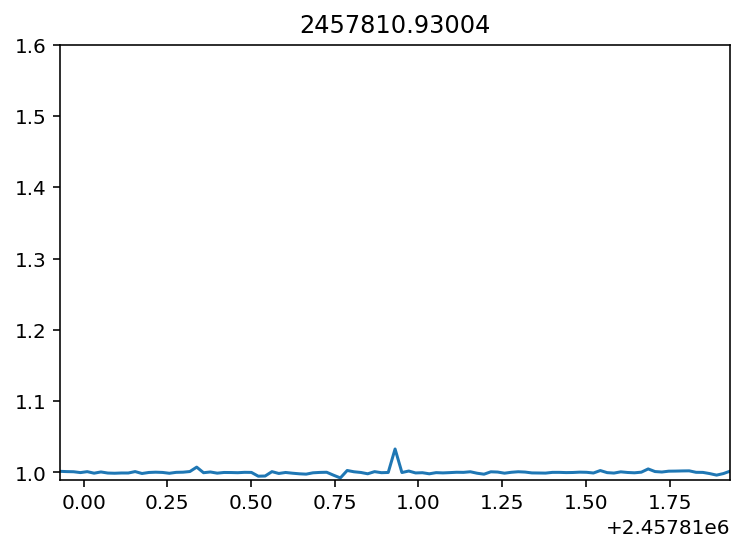

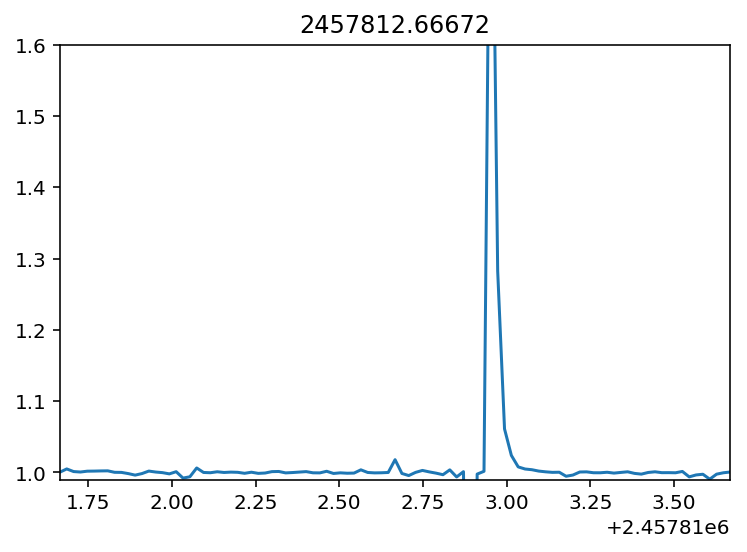

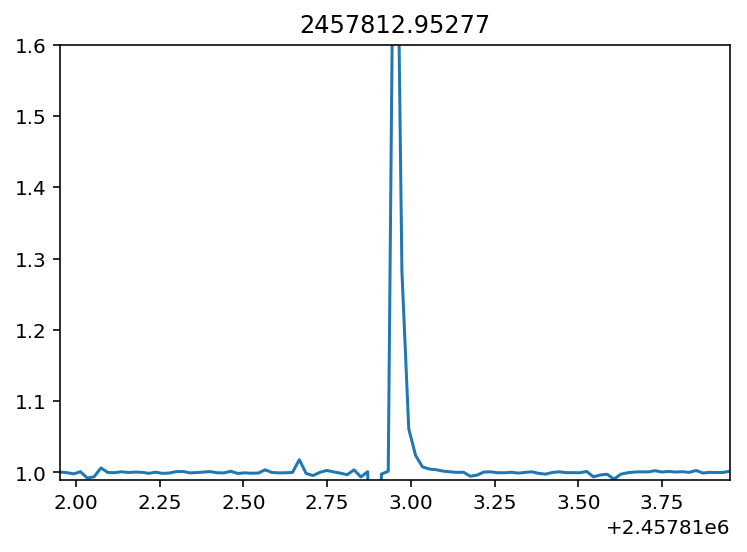

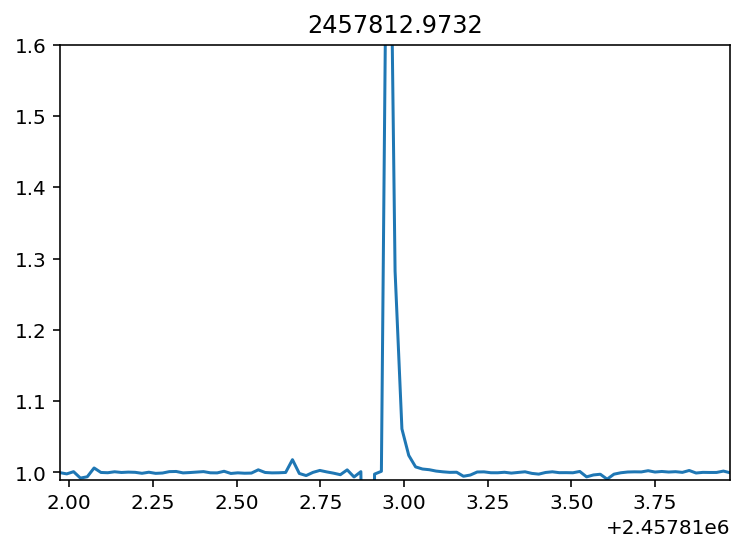

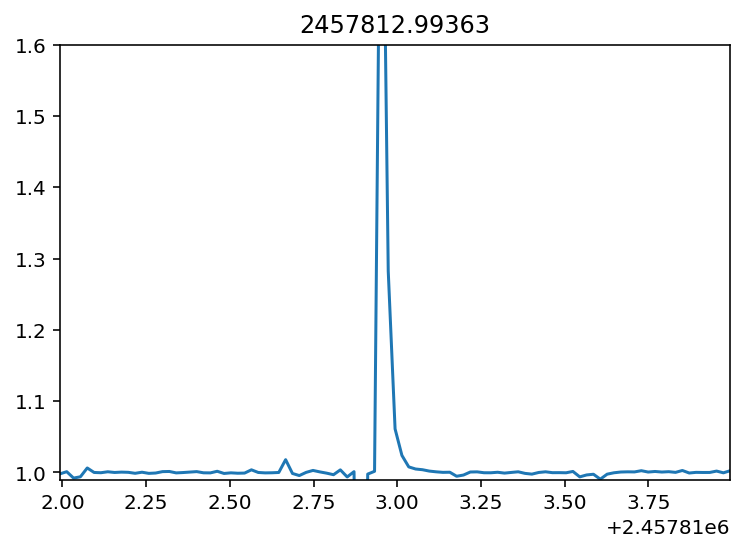

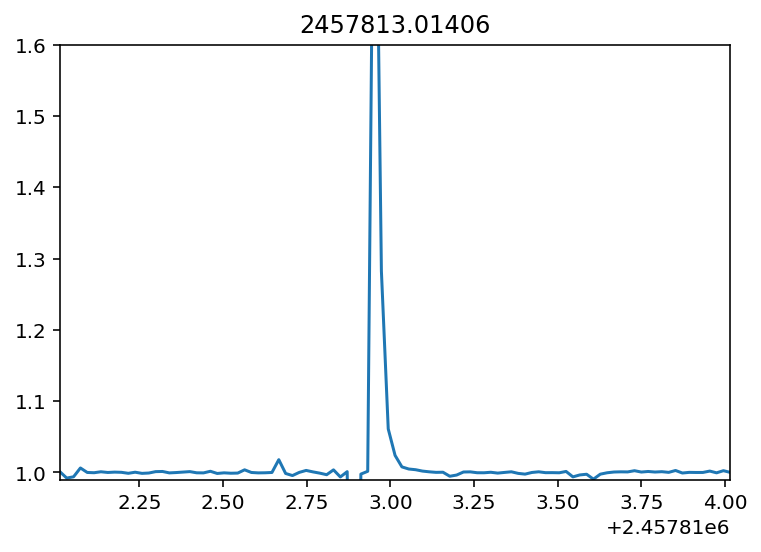

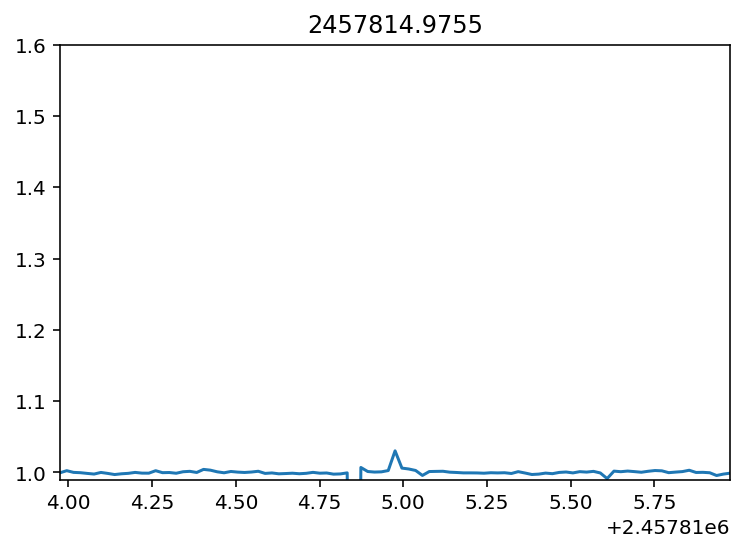

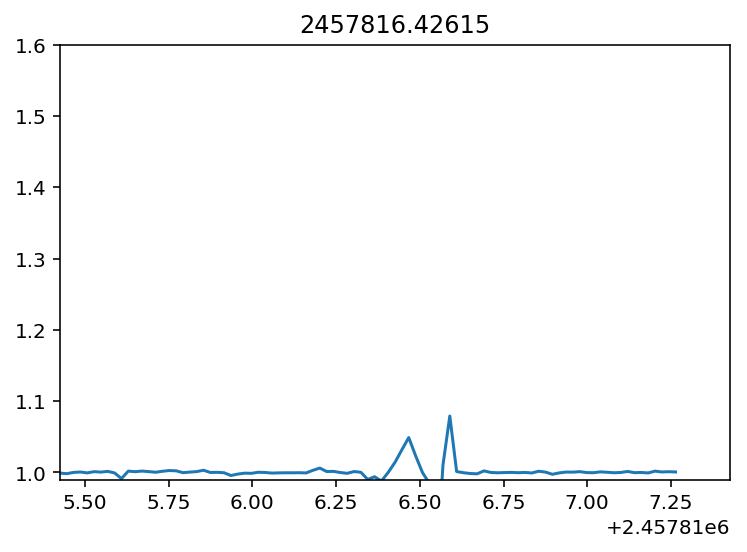

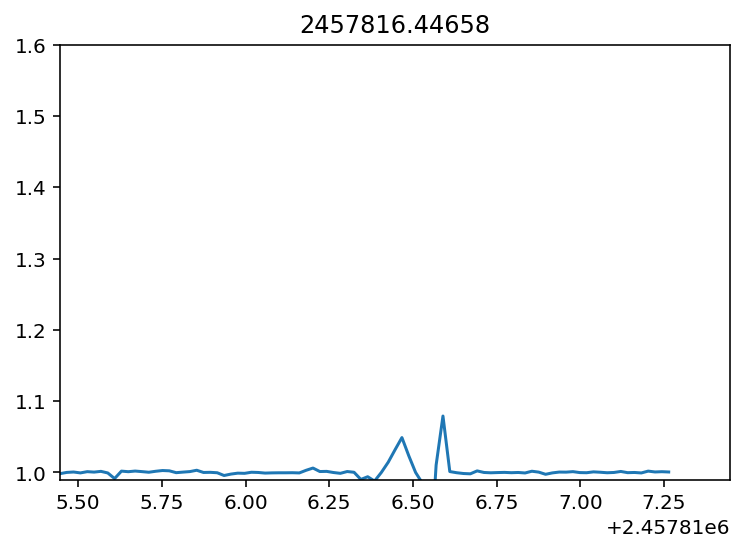

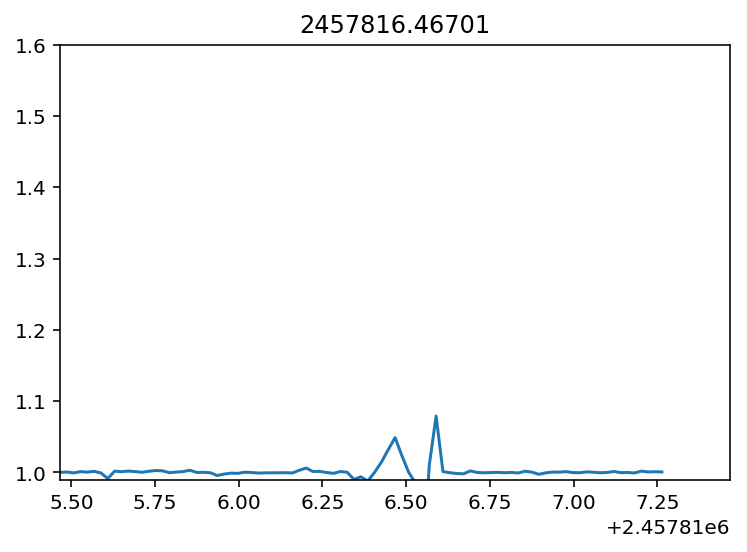

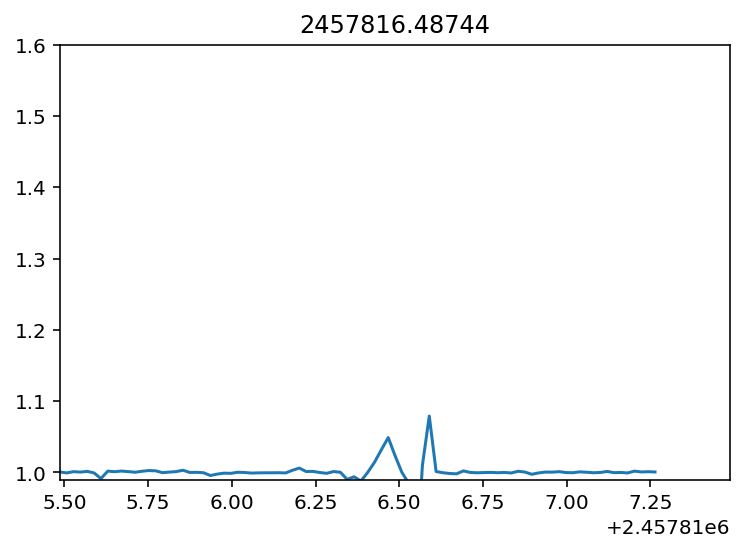

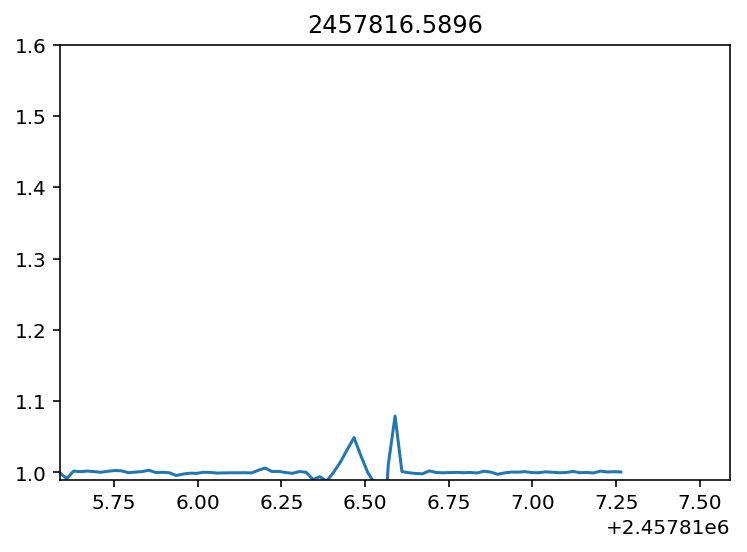

In [48]:
for t in k2_time[mask][candidate_flares]:
    plt.figure()
    plt.plot(k2_time[mask], filtered_fluxes)


    plt.xlim([t-1, t+1])
    plt.ylim([0.99, 1.6])
    plt.title(t)
    plt.show()

In [10]:
flares = np.array([2457745.11, 2457745.11949007, 2457752.88371535, 
                   2457759.93273949, 2457759.9736034, 2457771.29281912,  
                   2457773.45857741, 2457776.50289287,
                   2457803.39079186,  2457806.5168182 , 
                   2457813.01406197])

np.savetxt('flare_times.txt', flares)

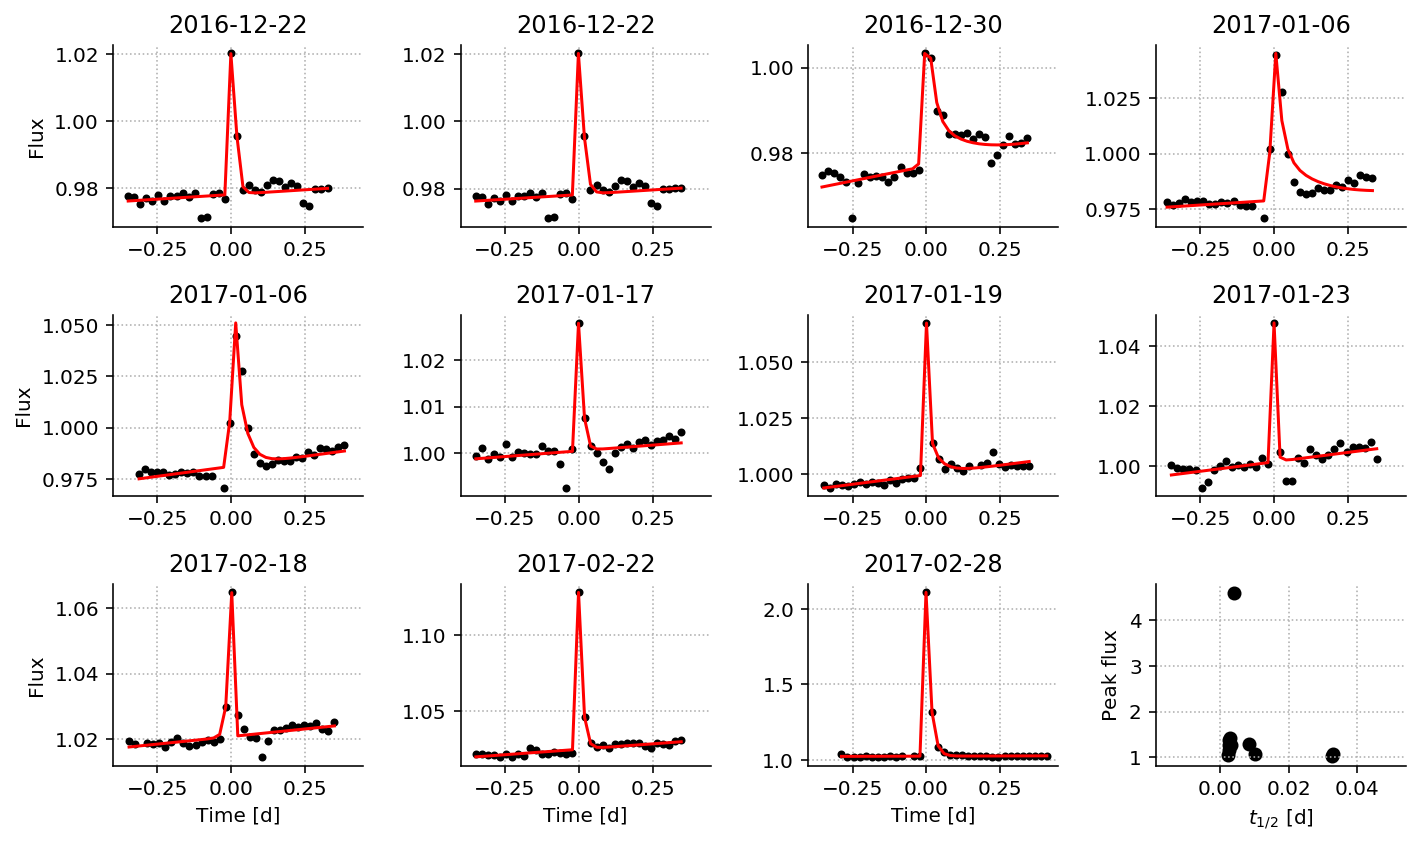

In [50]:
from libra.flares import flare_flux
from astropy.time import Time

#flare_times = [2457773.47900917, 2457752.88371535, 2457812.97319864]

def model(p, times):
    peak_flux, t0, halfdur, offset, slope = p
    return offset + flare_flux(times, t0, peak_flux, halfdur) + slope * (times - t0)

def chi2(p, times, fluxes):
    return np.nansum((model(p, times) - fluxes)**2)

from scipy.optimize import fmin_powell

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(3, 4)
nrepeat = 4
fit_results = []

ax0 = None

for i, t0 in enumerate(flares):
    chunk = np.abs(k2_time[mask] - t0) < 0.35
    chunk_time = k2_time[mask][chunk]
    chunk_flux = k2_flux[mask][chunk]
    
    bounds = [[0.0, 3], [t0 - 0.1, t0 + 0.1], 
              [0, 0.5], [0.9, 1.1], [-1, 1]]
    
    chunk_flux[chunk_flux < 0.9] = np.nan
    initp = [np.nanmax(chunk_flux) - 1, t0, 0.01, 1, 0]
    result = fmin_powell(chi2, initp, args=(chunk_time, chunk_flux), disp=0)

#     plt.plot(chunk_time, chunk_flux)
#     plt.plot(chunk_time, model(result, chunk_time))
#     plt.title(i)
    
    if i == 0:
        ax = plt.subplot(gs[i // nrepeat, i % nrepeat])
        ax0 = ax
    else: 
        ax = plt.subplot(gs[i // nrepeat, i % nrepeat], sharex=ax0)

        
    if i % nrepeat == 0:
        ax.set_ylabel('Flux')
    
    if i // nrepeat == nrepeat - 2:
        ax.set_xlabel('Time [d]')
        
    offset = 0.08
    ax.set_title(Time(result[1], format='jd').datetime.date())
    ax.plot(chunk_time - result[1], chunk_flux, 'k.')
    ax.plot(chunk_time - result[1], model(result, chunk_time), 'r')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(ls=":")
    fit_results.append(result)
#ax.set_yscale('log')

ax = plt.subplot(gs[2, 3])
fit_results = np.array(fit_results)

ax.scatter(abs(fit_results[:, 2]), 
           (fit_results[:, 0] + fit_results[:, 3]), color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Peak flux')
ax.set_xlabel('$t_{1/2}$ [d]')
ax.grid(ls=":")
fig.tight_layout()
#fig.subpots_adjust()
fig.savefig('trappist1_flares.pdf', bbox_inches='tight')

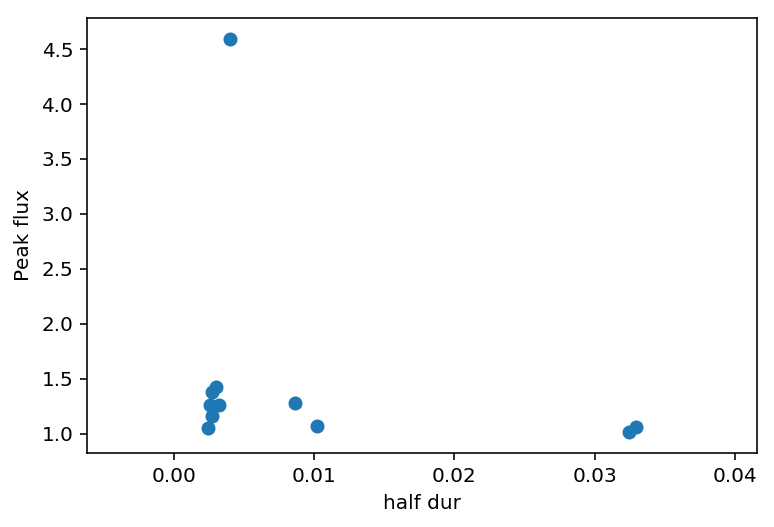

In [51]:
plt.scatter(abs(fit_results[:, 2]), (fit_results[:, 0] + fit_results[:, 3]))
plt.ylabel('Peak flux')
plt.xlabel('half dur')

np.savetxt("../libra/data/flares/trappist1_morris.txt", 
           np.vstack([abs(fit_results[:, 2]), 
                      (fit_results[:, 0] + fit_results[:, 3])]).T)

(-0.05, 0.1)

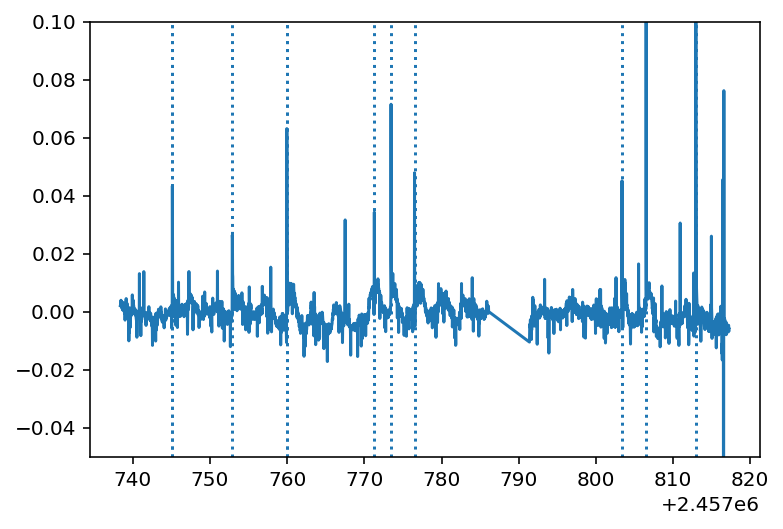

In [13]:
f = fits.getdata('../libra/data/trappist_everest_luger.fits')

k2_normed_time = f['TIME'] + 2454833
k2_normed_flux = f['FLUX'] / np.nanmedian(f['FLUX'])

k2_normed_time = k2_normed_time[~np.isnan(k2_normed_flux) & (k2_normed_flux > 0.8)]
k2_normed_flux = k2_normed_flux[~np.isnan(k2_normed_flux) & (k2_normed_flux > 0.8)]

p = np.polyfit((k2_normed_time - k2_normed_time.mean()), k2_normed_flux, 5)
k2_normed_flux -= np.polyval(p, k2_normed_time - k2_normed_time.mean())

med_flux = []
for t in flares:
    plt.axvline(t, ls=':')
    near_flare = (k2_normed_time - t > -0.2) & (k2_normed_time - t < -0.0001)    
    med_flux.append(np.median(k2_normed_flux[near_flare]))

plt.plot(k2_normed_time, k2_normed_flux)
plt.ylim([-0.05, 0.1])

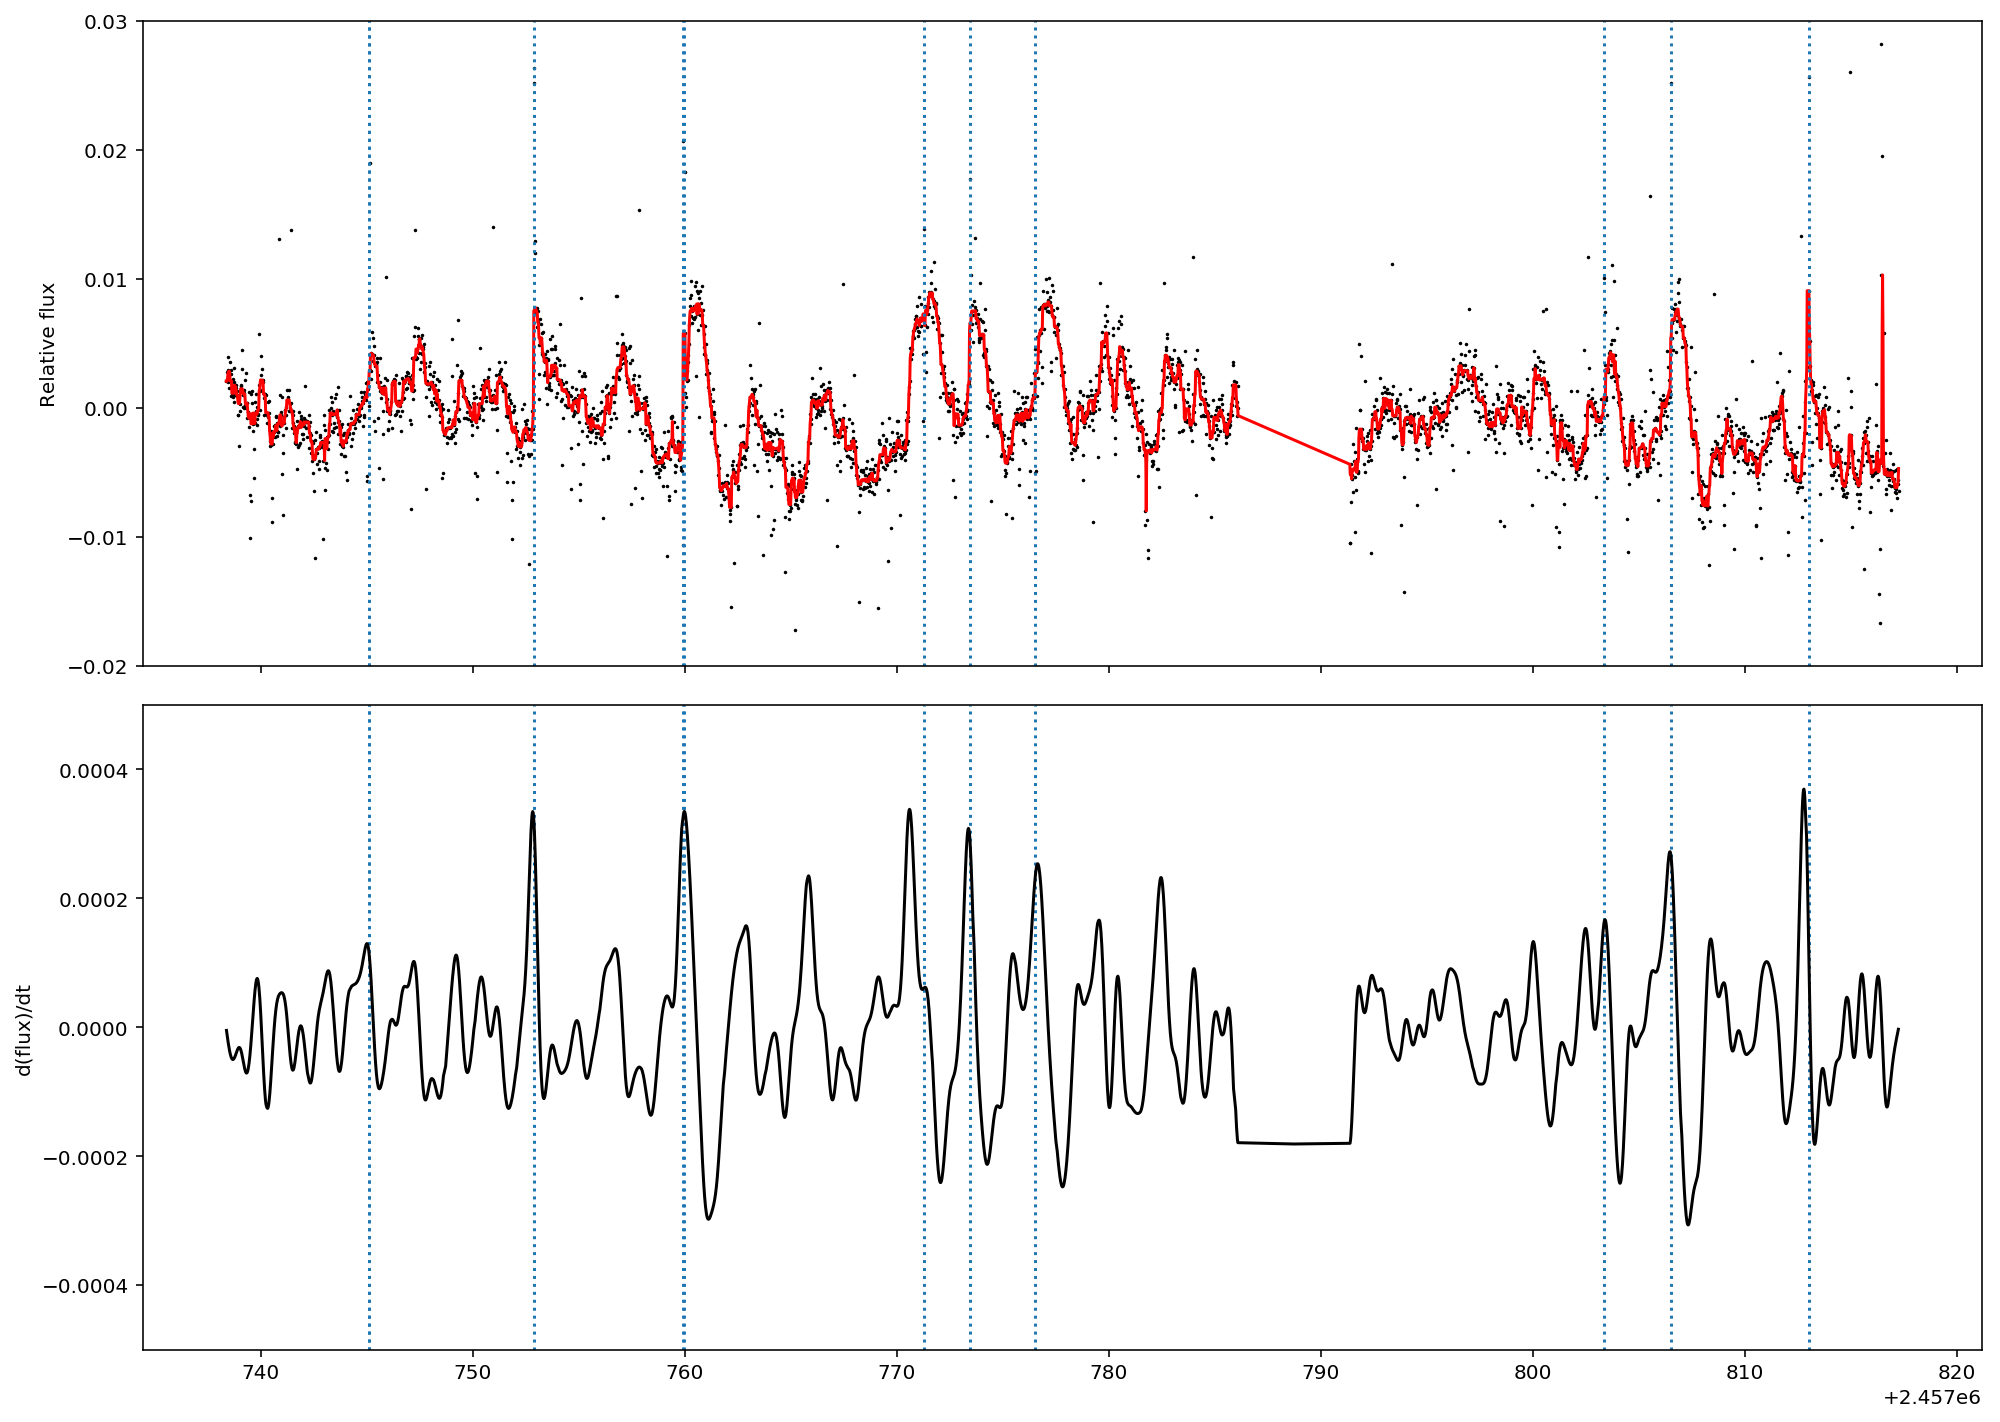

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax[0].plot(k2_normed_time, k2_normed_flux, 'k.', ms=1.5)

from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d

median_filtered = medfilt(k2_normed_flux, (9,))

ax[0].plot(k2_normed_time, median_filtered, 'r')

for axis in ax:
    for t in flares:
        axis.axvline(t, ls=':')
ax[0].set_ylim([-0.02, 0.03])
    
deriv_flux = np.diff(gaussian_filter1d(median_filtered, 10))
deriv_time = 0.5*(k2_normed_time[1:] + k2_normed_time[:-1])

ax[1].plot(deriv_time, deriv_flux, 'k', ms=1.5)
ax[1].set_ylim([-0.0005, 0.0005])

ax[0].set_ylabel('Relative flux')
ax[1].set_ylabel('d(flux)/dt')
fig.tight_layout()
fig.savefig('flares_rising_edge.png', dpi=250)